# LEVANTAR CLUSTER DE DASK EN EL FT-III

La librería permite levantar un cluster dask en  el FT3 de forma sencilla. Los ficheros de la librería son:

* **dask_cluster.py**: script python con todas las funciones necesarias para levantar el *scheduler* y los *workers* de un *cluster* de **dask**. Se puede utilizar como una línea de comandos:
    * python  dask_cluster.py -h: nos da una lista con los posibles inputs:
* **dask_submit_scheduler.sh**: script en bash que lanza al sistema de colas un *scheduler*.
* **dask_submit_workers.sh**: script en bash que lanza al sistema de colas varios *workers*. Lanza tantos workers como se le indique en el número de tareas de la reserva!!
* **dask_submit_cluster.sh**: script que lanza a cola el cluster completo (*scheduler* y *workers*). La reserva de recursos debe ser tal que el número de tareas solicitadas sea igual al número de *workers* deseados + 1 (que será la tarea que se encargue del *scheduler*).
* **dask_submit_all.sh**: script que permite lanzar un cluster dask completo (es decir un scheduler y los workers deseados) y una tarea adicional con el código python que se conectará y utilizará el cluster de dask creado.
* **wraper.sh**: pequeño script que se usa en conjunto con *dask_submit_all.sh*
* **inc_dask.py**: codigo python para ejemplificar el uso del script *dask_submit_all.sh*
* **inc_dask_module.py**: codigo python que solo contiene la función *inc(x)* para usarla como un módulo (se debe utilizar con el script **inc_dask_with_module.py**)
* **inc_dask_with_module.py**: código python que implementa el mismo ejemplo que el script **inc_dask.py** pero con la función *inc(x)* importada a través de su módulo (*inc_dask_with_module*). Este script se usa en conjunto con **inc_dask_module.py**)
* **PreLoad.py**: script python que se utiliza para mandar al cluster los módulos de python del usuario que se puedan necesitar para ejecutar el programa


## 1. Dask: Configuración 1

En este caso tenemos la siguiente configuración: tenenmos un jupyter-notebook levantado y queremos levantar un *scheduler* de dask en la reserva en la que tenemos el jupyter-notebook y vamos a lanzar *workers* al sistema de colas que se irán conectando al *scheduler* a medida que se vaya ejecutando la reserva. La configuración sería la siguiente:

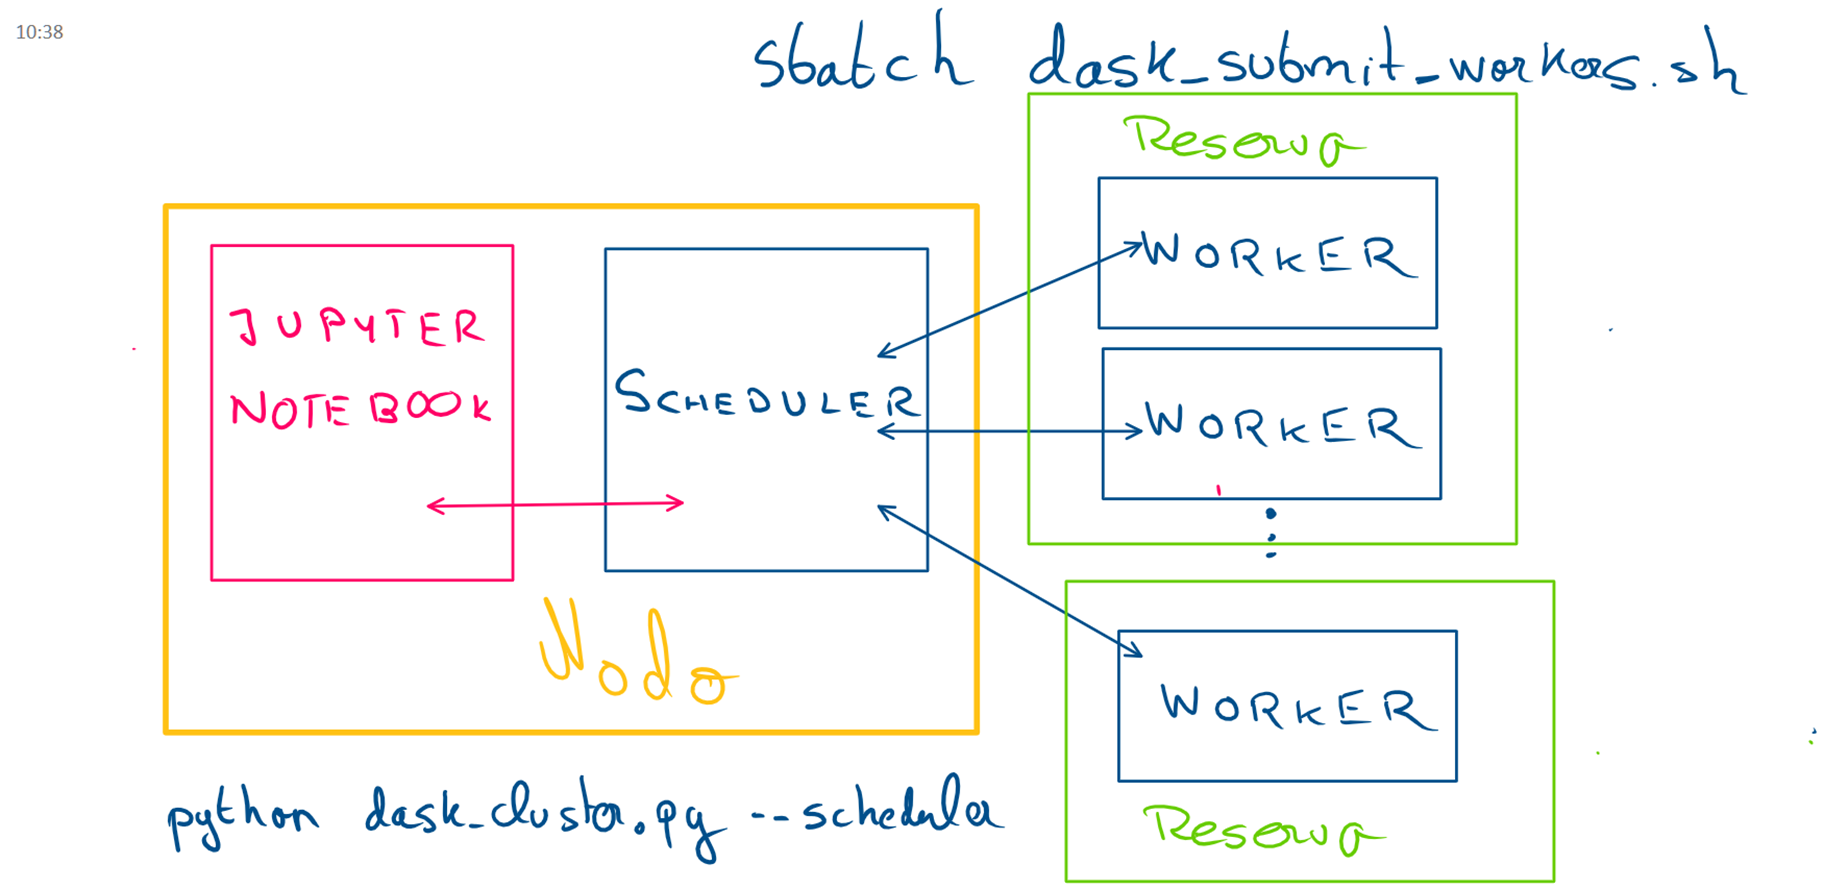

Para poder ejecutar esta configuración debemos hacer lo siguiente:

* Abro el terminal desde que lancé el Notebook.
* **Cargo los modulos o entornos conda necesarios. Tienen que ser los mismos que los del Notebook!!**
* Ejecuto:
    * python dask_cluster.py --scheduler
* Se crea automáticamente un fichero **scheduler_info.json** con la info del scheduler.
* Este fichero se le puede proporcionar al Client de dask.

#### NOTAS

* Si queremos cambiar el fichero donde se guarda la configuración del scheduler simplemente debemos usar:
    * python dask_cluster.py --scheduler -scheduler_address ./my_info_file.json (escribirá la información en en *./my_info_file.json*)
* Al ejecutar así el scheduler la terminal donde se ejecuta quedará bloqueada. Si se quiere tener la terminal libre se puede lanzar el scheduler en segundo plano sinmás que:
    * python dask_cluster.py --scheduler -scheduler_address ./my_info_file.json &> scheduler.txt &
    * Este comando pondrá el scheduler de dask en segundo plano y redigirá toda la salida al fichero *scheduler.txt*
    * Adicionalmente la información del schedculer se guardará en *./my_info_file.json*

Una vez hemos lanzado el scheduler podremos utilizar el json que crea para conectar el jupyter-notebook al scheduler sin más que:

In [ ]:
#Aqui pon el path de tu json file
path_to_schedule_json = "./scheduler_info.json"
from distributed import Client
client = Client(
    scheduler_file = path_to_schedule_json)

In [ ]:
client

### 1.1 Levantando workers (teoría!!!)

El cliente así creado solo tiene el *scheduler* hay que añadirle los *workers*.

**ATENCIÓN!!** 

En esta celda se explica con un **propósito didáctico** como usar el script para levantar workers. **NO SE DEBE UTILIZAR PARA LANZAR LOS WORKERS. LOS WORKERS SE DEBEN LANZAR AL SISTEMA DE COLAS. SE PROPORCIONA UN SCRIPT DE BASH dask_submit_workers.sh QUE ES EL QUE SE DEBE UTILIZAR PARA LANZAR LOS WORKERS!!**


Para levantar workers manualmente se utiliza el comando **--worker** pero se le debe proporcionar la dirección del scheduler al que el worker se tiene que conectar. Esto se puede proporcionar de dos modos:
* Proporcionando el nombre del fichero con la info del scheduler, que se crea al levantar el scheduler:
    * python dask_cluster.py --worker -scheduler_file ./scheduler_info.json
* Proporcionando la direccion del scheduler del siguiente modo:
    * python dask_cluster.py --worker -scheduler_address "tcp://10.120.10.7:8085" (se supone que el scheduler se ha levantado en dicha dirección IP y en dicho puerto!!)

Como se comentó antes esta forma manual de levantarlos **NO SE RECOMIENDA** es mejor usar el bash script **dask_submit_workers.sh** para lanzarlos a cola (ver siguiente celda). Si aún así el usuario quiere hacer caso omiso a estas recomendaciones (*play hard!! No rules!!! I write my own way!!*) se recomienda que los workers se levanten en computes diferentes (**POR FAVOR NO LO HAGAS EN EL FRONTAL!!!!**). 



### 1.2 Levantando workers en la práctica

Para levantar workers en la práctica se porporciona un bash script llamado: **dask_submit_workers.sh**.

Este script es un típico script para lanzar trabajos al sistema de colas del **FT-III**. Veamos como configurar el lanzamiento de los workers cuando se usa este script:

* #SBATCH -n 4:
    * Esta línea especifica el número de tareas (o workers) que queremos utilizar. En este caso vamos a utilizar 4.
* #SBATCH -c 1:
    * Esta línea especifica cuantas CPUs vamos a proporcionar a cada worker. En este caso daríamos 1 cpu por worker.
* SBATCH --mem-per-cpu=3G:
    * Esta línea especificaría la memoria que se va a asiganr a cada worker en función del número de cores que se haya asignado a cada worker. En este caso especificamos 3G de RAM por cada cpu (y como dedicamos una CPU por worker cada worker dispondrá de hasta 3G de RAM)
* SBATCH -t 00:10:00:
    * Esta línea especifica el tiempo que va a estar ejecutándose el trabajo. Es decir es la duración del worker una vez se haya levantado. En este caos durará 10 minutos.
* SCHED_FILE="./scheduler_info.json"
    * Esta fila almacena el nombre del json creado cuando se lanzó el scheduler para que los workers que lanvemos se conecten a él.

una vez lo hayamos configurado a nuestro gusto lo único que tenemos que hacer es lanzar el trabajo al sistema de colas sin más que:

* sbatch dask_submit_workers.sh

Cuando el sistema de colas ejecute el trabajo los workers se levantarán y se conectarán directamente al scheduler (utilizando el json generado cuando lanzamos el scheduler)

#### NOTA

Mientras el scheduler esté levantado podríamos lanzar más workers utilizando el método anterior. El propio el scheduler es capaz de integrar más workers a medida que se vayan levantando!

### 1.3 Dashboard

Si queremos acceder al dashboard hay que ejecutar, en el nodo donde se lanzo el scheduler, el siguiente comando:

* python dask_cluster.py --ssh_file  -scheduler_file ./scheduler_info.json

Esteo creará en el directorio un fichero **ssh_command.txt** con el comando completo para hacer la redirección de puertos necesaria para poder acceder al dashboard de dask.

Cuando se ejecute el comando en el terminal solo tendremos que ejecutar en un navegador la orden **localhost:PUERTO** donde **PUERTO** se puede encontrar en el comando necesario para la redireccion de puertos.

* Ejemplo. Supongamos que el comando que encontramos en **ssh_command.txt** es:
    * ssh -t -L 8787:localhost:8787 gferro@ft3.cesga.es ssh -L 8787:172.30.211.22:8787 ilk-249
* Lo ejecutamos en un terminal.
* Nos vamos al navegador y pegamos: **localhost:8787**

Ya tendríamos acceso al dashboard de dask!

### 1.4 Notas

Los nodos del CESGA se pueden comunicar por *ethernet* o por *inifiniband* (**OJO** algunos nodos no tienen *infiniband*). Para utilizar *inifiniband* se debe proporcionar a la línea de comandos **--ib**:

* python dask_cluster.py --worker -scheduler_file ./scheduler_info.json --ib
* python dask_cluster.py --scheduler --ib

## 2. Dask: Configuracion 2

En este caso la configuración que queremos es un poco más general. Suponemos que tendremos un jupyter-notebook y queremos levantar un *cluster* de **dask** completo en el FT3. Además queremos conectar el jupyter notebook a dicho *cluster*. La configuración se describe en la siguiente figura:

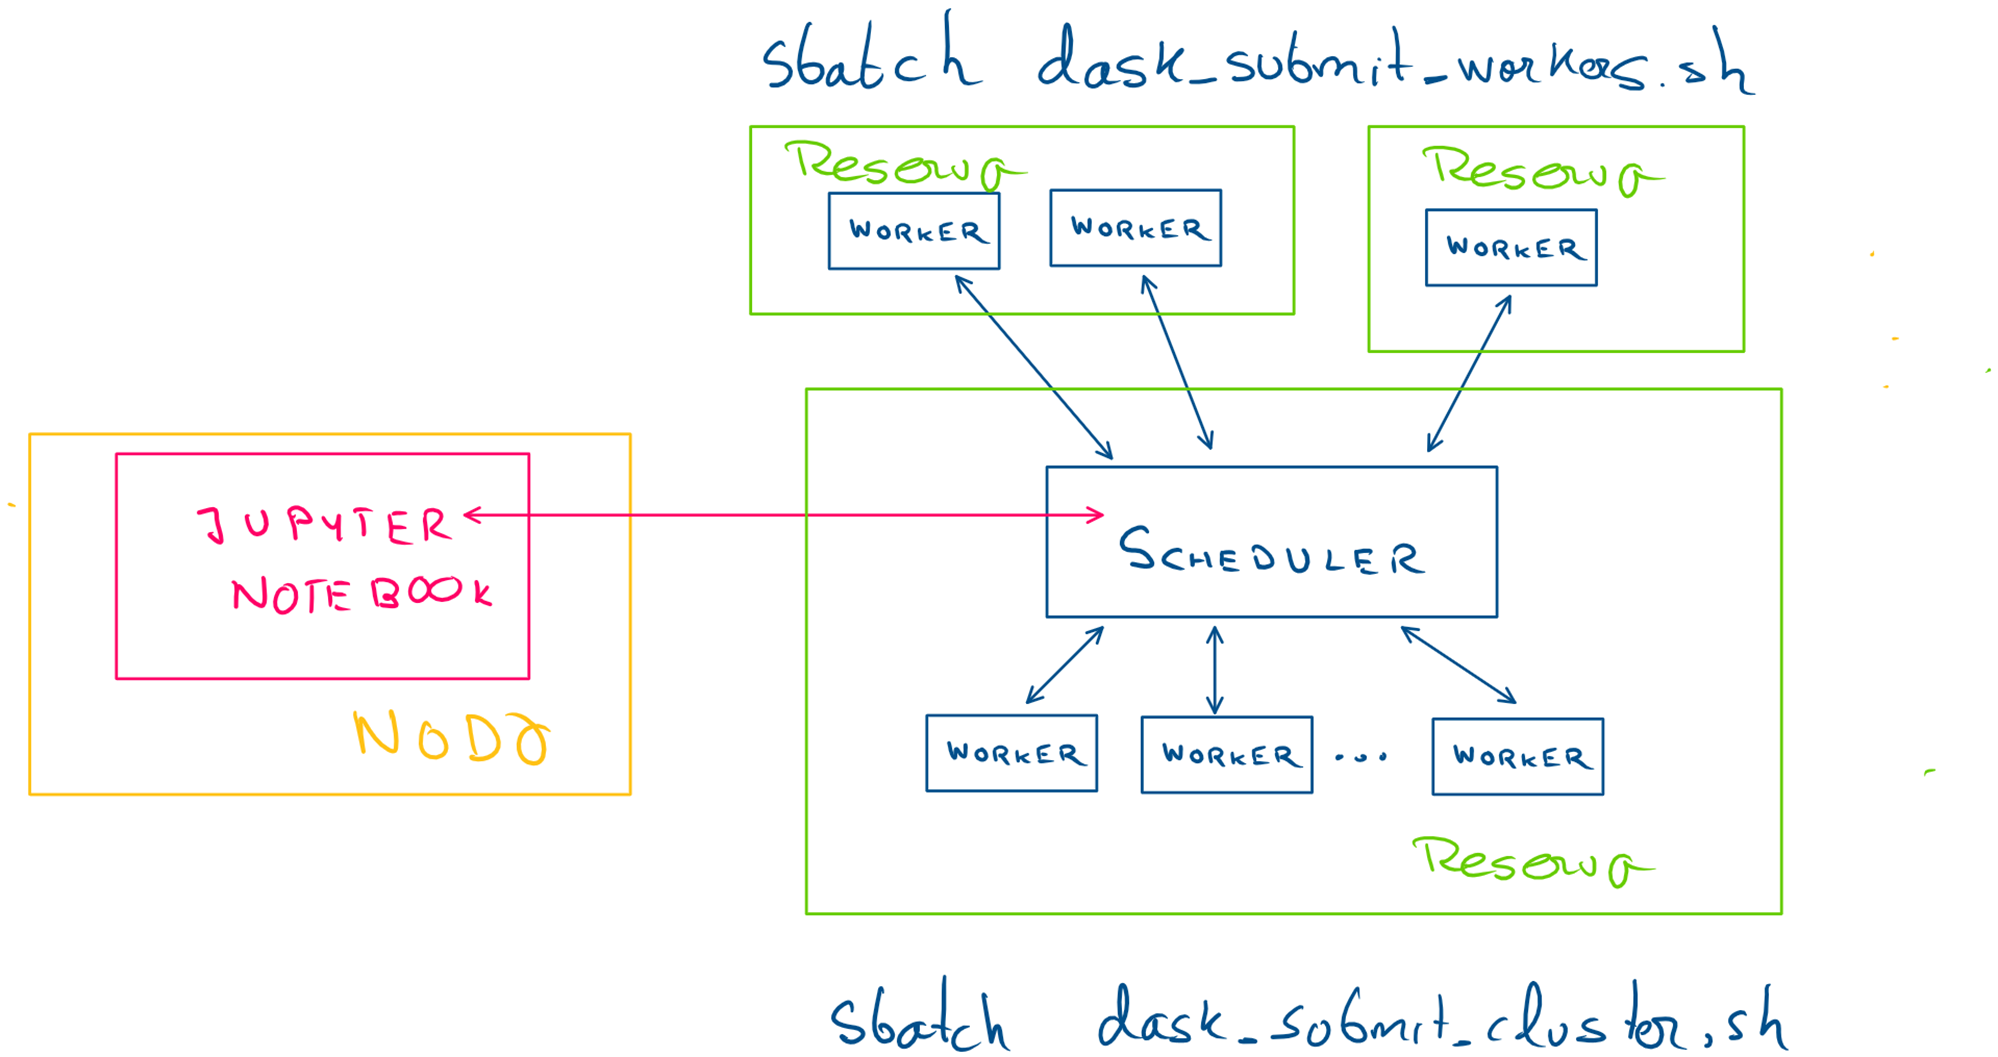


### 2.1 Levantar cluster dask de forma manual

La forma recomendada es la presentada en la siguiente sección (**2.2 Levantar el cluster dask de forma automática**). Esta explicación se proporciona por motivos pedagógicos!!

En este caso podemos levantar independientemente el scheduler y los workers. Para hacerlo de esta forma se pueden utilizar los siguientes scripts de bash:

* **dask_submit_scheduler.sh**: Envía al sistema de colas un trabajo que permite levantar un scheduler. Lineas que se pueden cambiar
    * SBATCH -c 1 
        * Esta línea especifica cuantas CPUs vamos a proporcionar al scheduler. En este caso daríamos 1 cpu.
    * SBATCH --mem-per-cpu=3G:
        * Esta línea especificaría la memoria que se va a asignar al scheduler en función del número de cores que se le haya asignado. En este caso especificamos 3G de RAM por cada cpu (y como dedicamos una CPU el scheduler dispondrá de hasta 3G de RAM)
    * SBATCH -t 00:20:00:
        * Esta línea especifica el tiempo que va a estar ejecutándose el trabajo. Es decir es la duración del scheduler una vez se haya levantado. En este caos durará 20 minutos
    * En este caso el scheduler creará por defecto el fichero con su información y le llamará: **./scheduler_info.json**

Para lanzar el scheduler a la cola se utilizará el siguiente comando:

* **sbatch dask_submit_scheduler.sh**

Una vez el scheduler está ejecutándose podremos lanzar los workers utilizando el script **dask_submit_workers.sh** como se especificó anteriormente. En este caso hay que asegurarse de proporcionarle correctamente el fichero *json* con la información del scheduler (ver sección **1.2 Levantando workers en la práctica**)


### 2.2 Levantar el cluster dask de forma automática

La anterior forma de levantar un cluster dask es un poco tediosa. Lo ideal es lanzar un solo comando y que se levante completamente el cluster de dask con su scheduler y sus workers. 

Esto se puede hacer con el script **dask_submit_cluster.sh**. Este script automatiza completamente el lanzamiento de un cluster de dask al **FT-III**.  Las filas que se pueden configurar son las siguientes:

* #SBATCH -n 5 # Number of tasks. 
    * Se configura el número de tareas que se van a lanzar dentro del trabajo de slurm. 
    * En este caso se debe tener en cuenta que se lanzan al mismo tiempo los workers y el scheduler.
    * Si queremos N_workers entonces el número de tareas debe ser: N_workers + 1
    * En este caso se lanzan 5 tareas por lo que se lanzarán 4 workers y 1 scheduler
* #SBATCH -c 1    
    * Esta línea especifica el número de CPUs para cada tarea (esto incluye worker y scheduler).
    * En este caso se utilizará 1 CPU para el scheduler y otra CPU para cada worker.
* SBATCH --mem-per-cpu=3G
    * Esta línea especificaría la memoria RAM que se va a asignar a cada tarea en función del número de cores asignados por tarea.
    * En este caso se especifica 3G de RAM por CPU y como se dedica una CPU por tarea a cada tarea se le asigan 3G de RAM.
    * Es decir el scheduler dispondrá de 3G de RAM y cada worker tambien
* SBATCH -t 00:10:00
    * tiempo que va a estar el trabajo en activo
    * es decir el tiempo que va a estar operativo el cluster de dask una vez se haya levantado.
    * en este caso se mantendrá 10 minutos
    
Una vez configurado se procede a lanzarlo al sistema de colas:

* **sbatch dask_submit_cluster.sh**

Atención la información del cluster de dask en este caso se almacenará en el fichero por defecto: **scheduler_info.json**.


#### NOTA

Una vez levantado el cluster podríamos añadir más workers utilizando el script **dask_submit_workers.sh** tal y como se explica en la sección **1.2 Levantando workers en la práctica**

In [ ]:
from distributed import Client

In [ ]:
path_to_schedule_json = "./scheduler_info.json"
client = Client(
    scheduler_file = path_to_schedule_json)

In [ ]:
client

### Dashboard de Dask

En este caso si todo fue bien cuando se levante el cluster el fichero **ssh_command.txt** se generará automaticamente en el directorio de lanzamiento.

Los pasos son los mismos que los explicados anteriormente.

## 3. Notas

Cosas que hay que tener en cuenta:

Las versiones cargadas de la librería **dask** tienen que ser consistentes en todos los trabajos, es decir debemos lanzar los *workers*, el *scheduler* y el jupyter-notebook que queremos conectar al *scheduler* con las mimas librerías de dask!!!

Para utilizar *infiniband* se debe especificar en la línea correspondiente de los script bash. En todos los scripts se ha incluído un **--ib /**. Si **NO** se quiuere utilizar *infiniband* se debería comentar. 

## 4. Ejemplo de funcionamiento

Vamos a ejecutar un ejemplo sencillo de como funciona dask. Está tomado de:

https://nbviewer.org/github/danbochman/Open-Source-Spotlight/blob/master/Dask/Dask.ipynb



In [ ]:
from time import sleep

#Espera 1 segundo y suma uno a la entrada

def inc(x):
    sleep(1)
    return x + 1


Sobre 4 números la operación tardará 4 segundos!

In [ ]:
%%time

data = [1, 2, 3, 4]

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
print(results)

## dask! 

Ejecutamos la configuración 2!!

In [ ]:
from distributed import Client

In [ ]:
path_to_schedule_json = './zalo.json'

In [ ]:
client = Client(scheduler_file = path_to_schedule_json)

In [ ]:
client

Hacemos unos pequeños cambios en el código principal para habilitar dask!!

Si tenemos un cluster de 4 *workers* el tiempo de la siguiente celda debe de ser de un poco más de 1 s.

In [ ]:
%%time
results = []

data = [1, 2, 3, 4]

for x in data:
    #enviamos al cluster
    y = client.submit(inc, x, pure=False)
    results.append(y)

#recogemos del cluster    
total = client.gather(results)

print(total)

## 5. Ejecutar Dask para un script python

En este caso lo que queremos es lanzar un programa cuyo cálculo se ejecute en un cluster de dask. En este caso en la misma reserva se lanzaría la creación del cluster de dask y del programa de python que se debe conectar a dicho cluster:

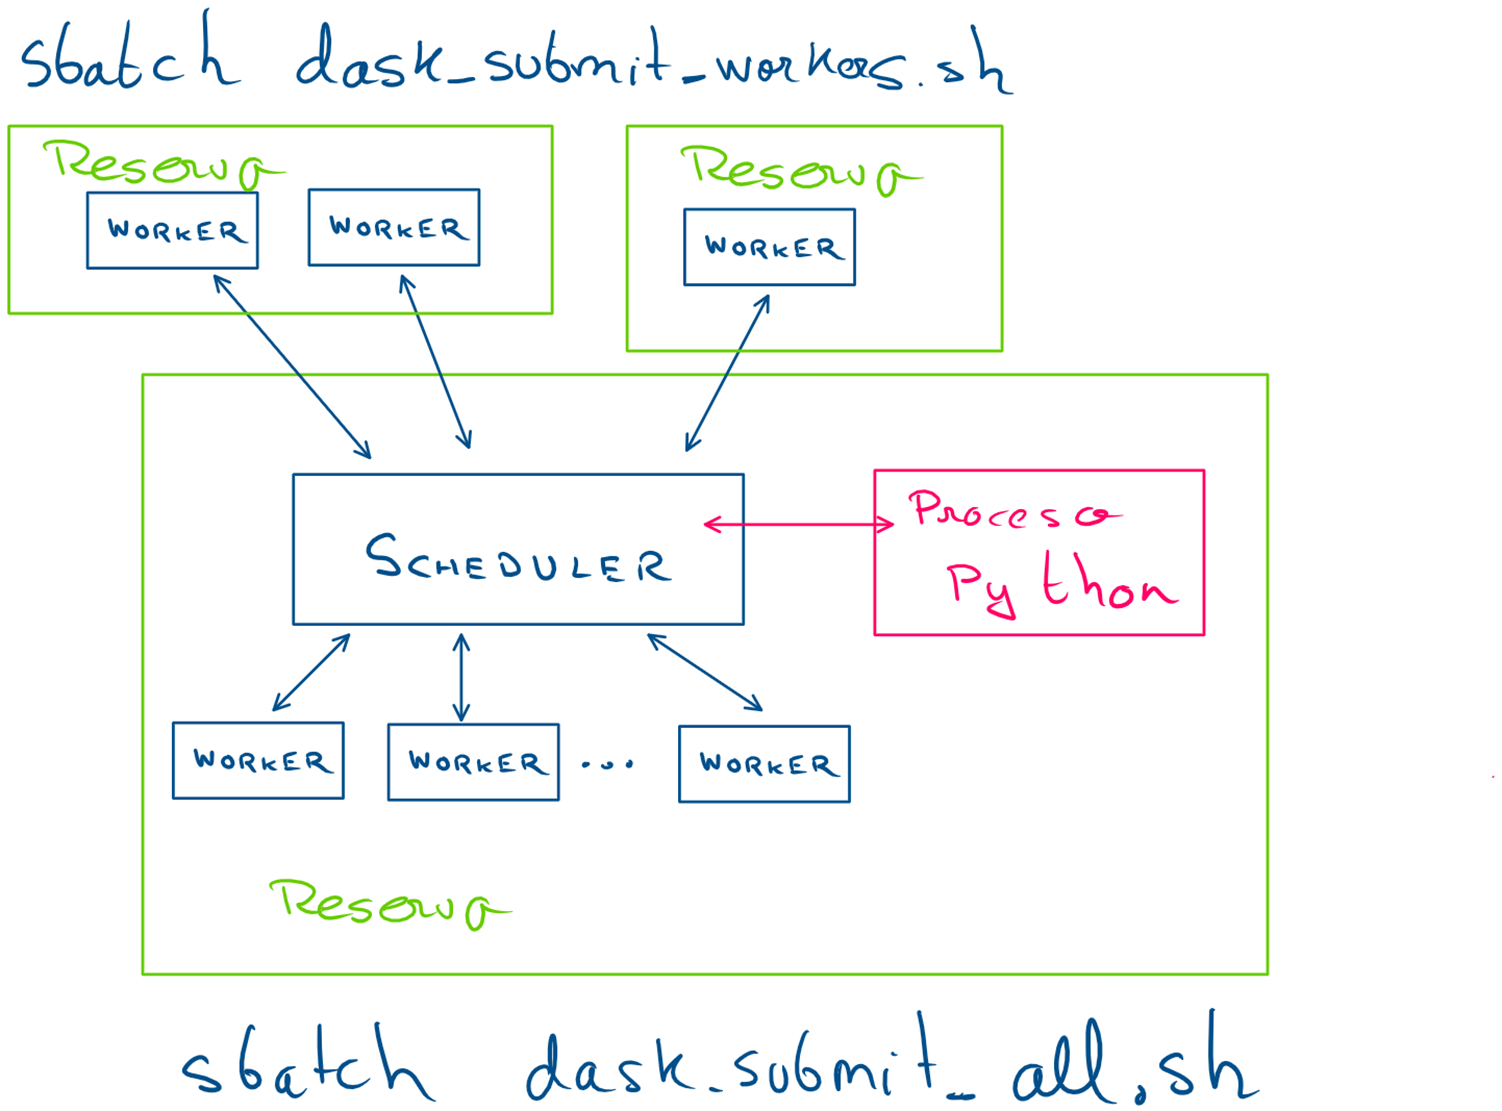



### Fichero dask_submit_all.sh

Para poder ejecutar esta casuística se proporciona el script de bash **dask_submit_all.sh**. En este caso las filas del fichero que se pueden configurar son las siguientes:

* #SBATCH -n 6 # Number of tasks. Se configura el número de tareas slurm que se van a lanzar (6 en este caso). Consideraciones:
    * El número de tareas que se debe configurar es igual al número de workers deseados + 2. 
    * El + 2 se debe a que necesitamos una tarea para levantar el scheduler al que se van a conectar los workers y una tarea adicional para nuestro código python.
* #SBATCH -c 1: Configura el número de CPUs dedicada a cada tarea (1 cpu en este caso).
* #SBATCH --mem-per-cpu=3G: Esta línea especificaría la memoria RAM que se va a asignar a cada tarea en función del número de cores asignados por tarea (en este caso 3G por CPU y a una CPU por tarea me daría 3G por tarea)
* #SBATCH -t 00:10:00: Tiempo que va a durar toda la reserva (Es decir las n tareas). 10 minutos en este caso

El script **dask_submit_all.sh** lo que hace es enviar al sistema de colas un fichero llamado **wraper.sh** que el usuario debe configurar adecuadamente. 

### Fichero wraper.sh

Este fichero se encarga de lanzar el cluster de dask y la tarea python que se conecta al cluster de dask. Aquí la línea que el usuario debe tocar es la relacionada con el lanzamiento de la tarea, que será la siguiente:

* python ./inc_dask.py

Aquí el usuario debe llamar al código python que va a utilizar el cluster de dask. En el ejmplo lo que se tiene es un script de python que implementa el ejemplo visto en la sección **4. Ejemplo de funcionamiento**. 

**NOTA**: En este escenario para pedir *infiniband* se debe modificar este fichero!!!. Por defecto está activado. Se debe comentar el *--ib* para **NO** usarla


### Código del usuario

Dentro del código del usuario se le tiene que indicar donde está el cluster de dask. Esto se puede hacer sin más que incluyendo el siguiente código en el programa del usuario:

* from dask_cluster import create_dask_client
* info = "./scheduler_info.json" #Aquí se le proporciona el fichero json que crea el scheduler.
* client = create_dask_client(info)

Con estas 3 líneas el código del usuario podrá acceder directamente al cluster de dask!!


#### NOTA

Una vez levantado el cluster podríamos añadir más workers utilizando el script **dask_submit_workers.sh** tal y como se explica en la sección **1.2 Levantando workers en la práctica**


## 6. El fichero PreLoad.py

Puede ocurrir que el código python que se necesite ejecutar en un cluster dask sea complejo y tenga muchas dependencias y módulos propios. Si esto ocurre hay que proporcionarle al cluster de dask (tanto al scheduler como a los workers) los módulos que el usuario utiliza (o al menos una ruta para que los pueda encontrar). En este caso entra el juego el fichero **PreLoad.py**. El fichero es muy sencillo:

* import sys
* sys.path.append("./")

En este fichero el usuario deberá indicar el path donde se encuentran todos los módulos que su programa necesite (se tiene que añadir tantos *sys.path.append* como sean necesarios). Además el usuario debe indicarle al cluster donde está este fichero PreLoad.py esto se hace pasando al script **dask_cluster.py** el argumento **-preload ./PreLoad.py**.

A nivel práctico el usuario debe descomentar la línea *-preload  ./PreLoad.py* en el fichero bash que utilice para lanzar el cluster, los workers o el scheduler de dask, es decir:

* *dask_submit_scheduler.sh*
* *dask_submit_workers.sh*
* *dask_submit_cluster.sh*
* *wraper.sh*


Para hacer pruebas de como funciona esto se recomienda al usuario que lance el script **dask_submit_all.sh** realizando, previamente los siguientes cambios en el fichero **wraper.sh**:

* Descomentar la línea **-preload ./PreLoad.py**
* Cambiar la línea **python ./inc_dask.py** por **python ./inc_dask_with_module.py**
